# 分析学生的消费行为和食堂的运营状况，为食堂运营提供建议。

## 初始化

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
# @github https://github.com/LKI/chinese-calendar
from chinese_calendar import is_workday

# 解决matplotlib无法正常显示中文的问题
plt.rcParams['font.sans-serif'] = ['STHeiti'] 
# plt.rcParams['font.sans-serif'] = ['Simhei']
plt.rcParams['axes.unicode_minus'] = False

# 读取数据
canteen = pd.read_csv('consume.csv')

## 处理数据集

In [26]:
# 筛选所有食堂
canteen = canteen[canteen.Dept.str.contains('食堂')]

# 格式化时间，每十分钟为一个时间段
canteen['Time'] = canteen['Time'].apply(lambda time: time[:-1]+'0')

'''
根据时间区间判断是早餐、午餐还是晚餐
'''
def time_map(clock:str):
    time_limit = [['06:00','09:30'],['10:30','14:30'],['16:00','22:00']]
    if time_limit[0][0] <= clock < time_limit[0][1]:
        return '早餐'
    elif time_limit[1][0]<=clock <time_limit[1][1]:
        return '午餐'
    elif time_limit[2][0]<=clock <time_limit[2][1]:
        return '晚餐'
    else:
        return ''

def isWork(date:list):
    return is_workday(datetime.date(date[0],date[1],date[2]))

# 判断是否是工作日
canteen['isWork'] = canteen['Date'].apply(lambda date: isWork(list(map(int,date.split('/')))))

# 创建新表
have_meal = canteen.copy()

# 判断用餐类别
have_meal['Meal'] = have_meal['Time'].apply(time_map)
have_meal = have_meal[have_meal.Meal!='']
have_meal.to_csv('temp.csv')

## lab1.各食堂就餐人次的占比饼图

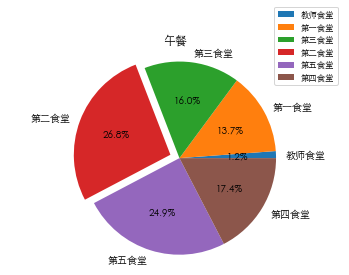

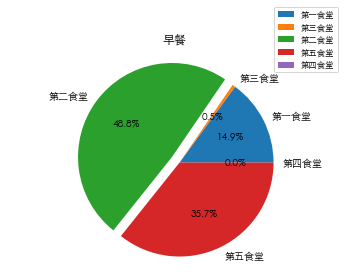

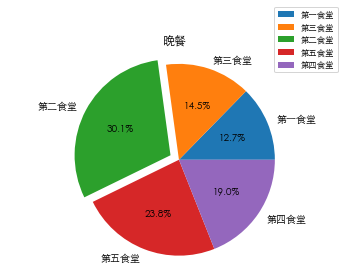

In [27]:
for name, group in have_meal.groupby(have_meal['Meal']):
    plt.figure(name)
    plt.title(name)
    count = []
    labels = []
    for name_t, group_t in group.groupby(group['Dept']):
        count.append(group_t.shape[0])
        labels.append(name_t)
    # 创建explode向量，凸显出图中占比最大的部分
    explode=tuple(map(lambda x: 0.1 if x==max(count) else 0,count))
    plt.pie(count,explode=explode,labels=labels,autopct='%3.1f%%')
    # 设置横纵坐标相等，使饼图变成圆形
    plt.axis('equal')
    # 设置图例的位置，防止与标签重合
    plt.legend(fontsize='small',bbox_to_anchor=(0,1.02,1,0.2),loc="upper right")
    plt.show()

## lab2.工作日和非工作日食堂就餐时间曲线图

### 准备数据

In [28]:
# 生成这一个月所有的工作日
counter = Counter(list(map(isWork,[[2019,4,i] for i in range(1,31)])))

# 统计出所有时段的客流量
dict_list = []
for name, group in canteen.groupby(canteen['isWork']):
    for name_t, group_t in group.groupby([group['Time'],group['Dept']]):
        count = 0
        for name_tt, group_tt in group_t.groupby(group_t['Date']):
            count+=group_tt.shape[0]
        count/=counter[name]
        dict_list.append({'Type':'工作日' if name else '休息日','Dept':name_t[1],'Time':name_t[0],'Count':count})

# 填补缺失时段的客流量为0
sequence = pd.DataFrame(dict_list[0:])
for name, group in sequence.groupby([sequence['Type'],sequence['Dept']]):
    for t in sequence['Time'].unique():
        if t not in group['Time'].values:
            sequence = sequence.append([{'Type': name[0],'Dept':name[1],'Time':t,'Count':0}])

# 筛选掉基本上无用的时间段
sequence = sequence[sequence['Time']>'06:00']

### 画图：工作日和非工作日食堂就餐时间曲线图

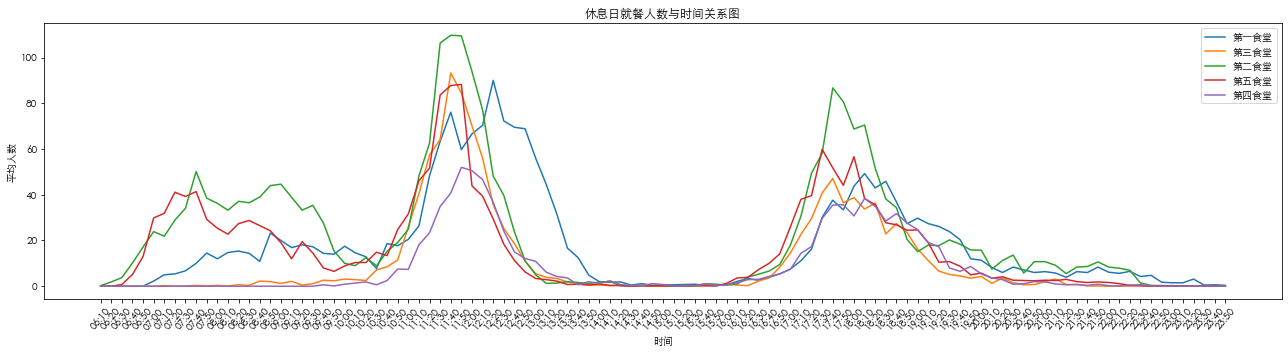

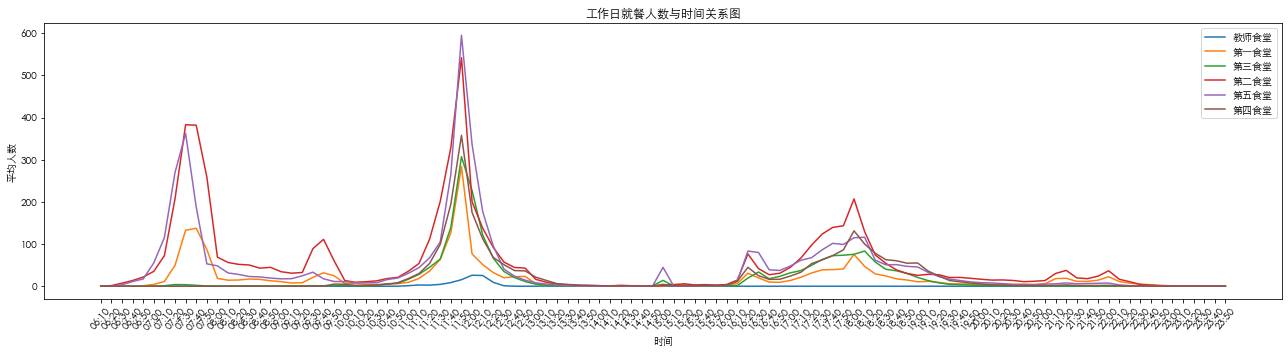

In [32]:
for name, group in sequence.groupby(sequence['Type']):
    group.sort_values(by="Time",inplace=True)
    plt.figure(name,figsize=(18,5))
    plt.title(name+"就餐人数与时间关系图")
    plt.xlabel('时间')
    plt.ylabel('平均人数')
    for name_t, group_t in group.groupby(group['Dept']):
        group_t.sort_values(by="Time",inplace=True)
        plt.plot(group_t['Time'],group_t['Count'],label=name_t)
    plt.legend()
    # 选装x轴标签，防止重叠
    plt.xticks(rotation=50) 
    plt.tight_layout() 
    plt.show()

## lab3.研究食堂物价与学生消费情况

### 准备数据

In [30]:
dict_list = []
for name, group in have_meal.groupby([have_meal['Dept'], have_meal['Meal']]):
    dict_t = {'Dept': name[0], 
              'Meal': name[1], 
              'AvgMoney': group['Money'].agg(['sum'])[0]/group.shape[0],
              'Count': group.shape[0]}
    dict_list.append(dict_t)
cost = pd.DataFrame(dict_list[0:])
cost

,Dept,Meal,AvgMoney,Count
0,教师食堂,午餐,8.972935,2143
1,第一食堂,午餐,2.632170,25155
2,第一食堂,早餐,2.339765,13500
3,第一食堂,晚餐,3.067921,18761
4,第三食堂,午餐,5.322255,29349
5,第三食堂,早餐,3.868614,469
6,第三食堂,晚餐,5.965070,21432
7,第二食堂,午餐,2.930964,49249
8,第二食堂,早餐,1.848534,44122
9,第二食堂,晚餐,2.972513,44505


### 通过Pearson线性相关系数验证物价越高，学生消费意愿越低

In [31]:
dict_list = []
# 求解Pearson相关系数
for name, group in cost.groupby('Meal'):
    # 线性处理
    std = MinMaxScaler(feature_range=(0, 1))
    group['AvgMoney'] = std.fit_transform(group['AvgMoney'].values.reshape(-1, 1))
    group['Count'] = std.fit_transform(group['Count'].values.reshape(-1, 1))
    # print(group)
    dict_t = {'时间段':name,
              '线性相关系数': group['AvgMoney'].corr(group['Count'])}
    dict_list.append(dict_t)
relationship = pd.DataFrame(dict_list[0:])
relationship

,时间段,线性相关系数
0,午餐,-0.715571
1,早餐,-0.903313
2,晚餐,-0.346169
